# Predicting Stock Prices for a Portfolio

In this notebook we will predict the stock prices of a portfolio using Linear Regression.

## Data and Inputs:

The data will use the following stocks in the portfolio:

- Apple
- Amazon
- Exelon Corporation 
- Nasdaq
- Royal Gold Inc.
<br>

**Training and Testing Data Period:** <br>
Start Date: July 1, 2015 <br>
End Date: Dec 31, 2018

# Set up the notebook
We will begin by importing all the necessary Python modules required to run the notebook.

In [1]:
%matplotlib inline

import quandl
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
from dateutil.parser import parse
from sklearn import metrics

# Load and Explore the Data
We will trading data, collected over the time period of:

**Start Date:** July 1, 2015 <br> 
**End Date:** Dec 31, 2018    
    
The cell below will download this data from the quandl API, giving you data in the form of a pandas dataframe.

In [2]:
start_date = "2015-7-1"
end_date = "2017-12-31"

In [3]:
dfAAPL = quandl.get("WIKI/AAPL", start_date="2015-7-1", end_date="2017-12-31")
dfAAPL = dfAAPL.rename(columns={'Adj. Close':'AAPL'})

dfAMZN = quandl.get("WIKI/AMZN", start_date="2015-7-1", end_date="2017-12-31")
dfAMZN = dfAMZN.rename(columns={'Adj. Close':'AMZN'})

dfEXC = quandl.get("WIKI/EXC", start_date="2015-7-1", end_date="2017-12-31")
dfEXC = dfEXC.rename(columns={'Adj. Close':'EXC'})

dfNDAQ = quandl.get("WIKI/NDAQ", start_date="2015-7-1", end_date="2017-12-31")
dfNDAQ = dfNDAQ.rename(columns={'Adj. Close':'NDAQ'})

dfRGLD = quandl.get("WIKI/RGLD", start_date="2015-7-1", end_date="2017-12-31")
dfRGLD = dfRGLD.rename(columns={'Adj. Close':'RGLD'})


# Pre-Process the Data

The /quandl dataframes have the following attributes:
* Date
* Open
* High
* Low
* Close
* Volume
* Ex-Dividend
* Split Ratio
* Adj. Open
* Adj. High
* Adj. Low
* Adj. Close
* Adj. Volume

Of all these columns, we will use only ***Adj. Close***. This is because the trading data is very volatile and 
changes several times within a day. Adjusted closing price factors a stock's value to reflect any corporate 
actions such as dividends, rights offerings and stock splits. For more information, [visit this post.](https://www.investopedia.com/terms/a/adjusted_closing_price.asp#:~:text=The%20adjusted%20closing%20price%20amends,detailed%20analysis%20of%20past%20performance.)

This is the reason why you will notice that each of the stock's adjusted price has been renamed to its ticker symbol in the cell above.

**Below, we will create a new DataFrame and join the portfolio value from the individual DataFrames above.**

In [4]:
start_date="2015-07-1"
end_date="2017-12-31"

Date = pd.date_range(start_date, end_date)

df=pd.DataFrame(index=Date)

df = pd.concat([dfAAPL, dfAMZN, dfEXC, dfNDAQ, dfRGLD], axis=1)
df = df.dropna()
df = df[['AAPL', 'AMZN', 'EXC', 'NDAQ', 'RGLD']]

df

,AAPL,AMZN,EXC,NDAQ,RGLD
Date,,,,,
2015-07-01,121.243068,437.39,29.107162,46.691199,58.987619
2015-07-02,121.089838,437.71,29.400710,47.093792,60.214716
2015-07-06,120.668456,436.04,29.299803,46.739127,61.282387
2015-07-07,120.371574,436.72,30.061194,46.815812,59.548025
2015-07-08,117.383593,429.70,29.905246,45.876428,59.678465
...,...,...,...,...,...
2017-12-22,175.010000,1168.36,39.010000,76.090000,86.560000
2017-12-26,170.570000,1176.76,38.810000,76.130000,87.650000
2017-12-27,170.600000,1182.26,38.990000,76.340000,86.730000


# Visualize the Data

We will now plot the data from the DataFrame that we created to visualize the progress.

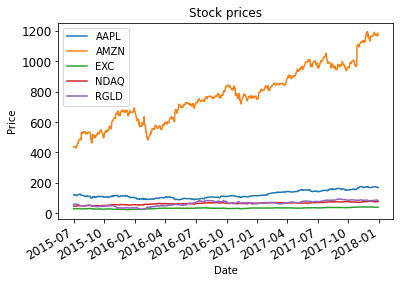

In [5]:
def plot_data(df, title="Stock prices"):
    """Plot stock prices with a custom title and meaningful axis labels."""
    ax = df.plot(title=title, fontsize=12)
    ax.set_xlabel("Date")
    ax.set_ylabel("Price")
    plt.show()
    
plot_data(df)

# Normalize the Data

Since the stocks trade at significantly different prices, it is hard to make a fair comparison. We will make them all 
begin at one fair point so that the comparison is on an equal footing. We will achieve this using data normalization. We will normalize price data, so that each value begins at 1.

In [6]:
def normalize_data(df):
    df = df/df.iloc[0, :]
    return df
df = normalize_data(df)
df.head()

,AAPL,AMZN,EXC,NDAQ,RGLD
Date,,,,,
2015-07-01,1.000000,1.000000,1.000000,1.000000,1.000000
2015-07-02,0.998736,1.000732,1.010085,1.008622,1.020803
2015-07-06,0.995261,0.996914,1.006618,1.001026,1.038903
2015-07-07,0.992812,0.998468,1.032777,1.002669,1.009500
2015-07-08,0.968167,0.982418,1.027419,0.982550,1.011712


# Plot Normalized Data

On plotting this normalized data, we will find that the stocks movement is relatively closer together. Hence we can
make a fair comparison.

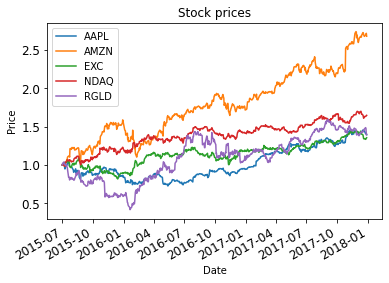

In [7]:
plot_data(df)

In [8]:
%%html
<style>
table {float:left}
</style>

# Create a Portfolio

We will now use an investment value and assign weights to each stock in the portfolio.

Assuming the ***investment value is $10,000*** and we assign weightages in the following order:

Stock | Weights
:--- | :---
Apple|25%
Amazon|25%
Exelon Corporation| 10%
Nasdaq| 30%
Royal Gold Inc.| 10%

The cell below returns allocated weights for each stock price.

In [9]:
weight = {'AAPL':0.25, 'AMZN': 0.25, 'EXC': 0.1,'NDAQ': 0.3, 'RGLD': 0.1}

def allocated_df():
    df['AAPL']=df['AAPL']*weight['AAPL']
    df['AMZN']=df['AMZN']*weight['AMZN']
    df['EXC']=df['EXC']*weight['EXC']
    df['NDAQ']=df['NDAQ']*weight['NDAQ']
    df['RGLD']=df['RGLD']*weight['RGLD']
    return df

allocated_df().head()

,AAPL,AMZN,EXC,NDAQ,RGLD
Date,,,,,
2015-07-01,0.250000,0.250000,0.100000,0.300000,0.100000
2015-07-02,0.249684,0.250183,0.101009,0.302587,0.102080
2015-07-06,0.248815,0.249228,0.100662,0.300308,0.103890
2015-07-07,0.248203,0.249617,0.103278,0.300801,0.100950
2015-07-08,0.242042,0.245605,0.102742,0.294765,0.101171


# Assign the Investment Amount

The cell below assigns the investment amount with the weightage for each stock. We now get an extra column called ***Portfolio Val***
which indicates the day/'s gain or loss for the entire invested amount.

In [10]:
investment_value=10000
portfolio = ['AAPL', 'AMZN', 'EXC', 'NDAQ', 'RGLD']
df = df*investment_value
df["Portfolio Val"] = df[portfolio].sum(axis=1)
df

,AAPL,AMZN,EXC,NDAQ,RGLD,Portfolio Val
Date,,,,,,
2015-07-01,2500.000000,2500.000000,1000.000000,3000.000000,1000.000000,10000.000000
2015-07-02,2496.840442,2501.829031,1010.085093,3025.867378,1020.802621,10055.424566
2015-07-06,2488.151659,2492.283774,1006.618342,3003.079450,1038.902539,10029.035764
2015-07-07,2482.030016,2496.170466,1032.776552,3008.006569,1009.500410,10028.484013
2015-07-08,2420.418641,2456.046092,1027.418847,2947.649353,1011.711712,9863.244645
...,...,...,...,...,...,...
2017-12-22,3608.659917,6678.021903,1340.219995,4888.929875,1467.426587,17983.258276
2017-12-26,3517.108291,6726.033974,1333.348834,4891.499952,1485.905041,17953.896092
2017-12-27,3517.726883,6757.470450,1339.532879,4904.992859,1470.308547,17990.031618


In [11]:
df.describe()

,AAPL,AMZN,EXC,NDAQ,RGLD,Portfolio Val
count,629.000000,629.000000,629.000000,629.000000,629.000000,629.000000
mean,2535.721572,4451.436411,1138.981482,4148.425086,1099.031372,13373.595923
std,507.187034,1065.309928,141.148745,517.074148,289.779223,2352.693243
min,1820.478525,2456.046092,818.741340,2947.649353,419.438576,9500.286457
25%,2166.288949,3577.470907,1038.655613,3852.466429,842.419570,11281.620234
50%,2345.850303,4382.644779,1145.657948,4243.404754,1146.820239,13302.268737
75%,2979.011651,5420.962985,1219.646102,4485.868853,1342.920516,15365.576956
max,3637.733744,6835.032808,1456.342620,5093.251034,1593.197851,18309.025416


# Write the Data to a CSV File

We will now write this data to a csv file titled *portfolio.csv*.

In [12]:
df.to_csv('portfolio.csv', sep='\t', encoding='utf-8')

# Capital Asset Pricing Model: Regression Analysis


## ${r}_{p}(t) = {\beta}_{p}{r}_{m}(t) + {\alpha}_{p}(t) $

In formal financial language, the regression model is the same as the Capital Asset Pricing Model (CAPM) equation where: <br />

${r}_{p}(t)$: Return on portfolio for a given day *t* <br />
${\beta}_{p}$: Co-efficient <br />
${r}_{m}$: Market returns; viz S&P 500 values <br />
${\alpha}_{p}(t)$: Intercept <br />

The CAPM emphasizes that the return on any stock or portfolio is due to the markets. This is why ${r}_{m}(t)$ is the independent x-variable in this equation. Since we are predicting the returns on the portfolio value, it is the dependent y-variable in this equation, represented by ${r}_{p}(t)$.

# Create a New Dataframe for the Model Variables

We will now read in the csv file containing the portfolio returns. We will use this data regarding the daily portfolio returns as the dependent variable in our Regression Model.

In [13]:
dfXY = pd.read_csv("portfolio.csv", sep='\t')
dfXY.set_index('Date')

,AAPL,AMZN,EXC,NDAQ,RGLD,Portfolio Val
Date,,,,,,
2015-07-01,2500.000000,2500.000000,1000.000000,3000.000000,1000.000000,10000.000000
2015-07-02,2496.840442,2501.829031,1010.085093,3025.867378,1020.802621,10055.424566
2015-07-06,2488.151659,2492.283774,1006.618342,3003.079450,1038.902539,10029.035764
2015-07-07,2482.030016,2496.170466,1032.776552,3008.006569,1009.500410,10028.484013
2015-07-08,2420.418641,2456.046092,1027.418847,2947.649353,1011.711712,9863.244645
...,...,...,...,...,...,...
2017-12-22,3608.659917,6678.021903,1340.219995,4888.929875,1467.426587,17983.258276
2017-12-26,3517.108291,6726.033974,1333.348834,4891.499952,1485.905041,17953.896092
2017-12-27,3517.726883,6757.470450,1339.532879,4904.992859,1470.308547,17990.031618


# Clean and Process S&P 500 data

As mentioned above, the independent variable comes from the S&P 500 data which we will read from the csv file *S&P500.csv*.



In [14]:
data = pd.read_csv("S&P500.csv")
data['Date']  # as a Series
date_array = data['Date'].values  # as a numpy array

In [15]:
d_list = []
for date in date_array:
    dt = parse(date)
    d_item = (str(dt.date()))    
    d_list.append(d_item)
dfDate = pd.DataFrame(d_list,columns=['Date'])
dfDate.set_index('Date')

""
Date
2018-03-29
2018-03-28
2018-03-27
2018-03-26
2018-03-23
...
2015-07-08
2015-07-07
2015-07-06


In [16]:
dfSP500 = pd.read_csv("S&P500.csv")
dfSP500.set_index('Date')
dfSP500 = dfSP500.rename(columns={'Price':'SP500', 'Date':'ODate'})
for i, col in enumerate(dfSP500.columns):
    dfSP500.iloc[:, i] = dfSP500.iloc[:, i].str.replace(',', '')
    
dfSP500 = dfSP500.join(dfDate)
dfSP500 = dfSP500.dropna()
dfSP500 = dfSP500[['Date', 'SP500']]
dfSP500['SP500'] = dfSP500['SP500'].astype(float)
dfSP500 = dfSP500[::-1]
dfSP500.reset_index(inplace=True, drop=True)

#### Append the Column Containing Market Return Values to the Variable Dataframe

In [17]:
dfXY = dfXY.join(dfSP500, lsuffix='SP500')
dfXY = dfXY.dropna()
dfXY = dfXY[['Date', 'Portfolio Val', 'SP500']]
dfXY['Portfolio Val'] = dfXY['Portfolio Val'].astype(float)
dfXY

,Date,Portfolio Val,SP500
0,2015-07-01,10000.000000,2077.42
1,2015-07-02,10055.424566,2076.78
2,2015-07-06,10029.035764,2068.76
3,2015-07-07,10028.484013,2081.34
4,2015-07-08,9863.244645,2046.68
...,...,...,...
624,2017-12-20,17983.258276,2679.25
625,2017-12-21,17953.896092,2684.57
626,2017-12-22,17990.031618,2683.34
627,2017-12-26,17974.392222,2680.50


# Run the Regression Analysis

In [56]:
y = dfXY[["Portfolio Val"]].to_numpy()
x = dfXY[["SP500"]].to_numpy()

#### Plot Data on a Scatter-plot

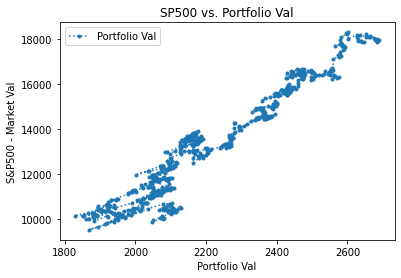

In [57]:
dfXY.plot(y='Portfolio Val', x='SP500', style='.', linestyle = ':')
plt.title('SP500 vs. Portfolio Val')
plt.xlabel('Portfolio Val')
plt.ylabel('S&P500 - Market Val')
plt.show()

In [58]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=0)

### Linear Regression:

In [59]:
model = LinearRegression().fit(x_train, y_train)
model.intercept_, model.coef_

(array([-11065.28056245]), array([[10.99550251]]))

In [60]:
y_pred=model.predict(x_test)

#### To compare the predicted values y_pred with the actual output values y_test we will execute this script:

In [61]:
dfYt = pd.DataFrame(y_test, columns=['y_test'])
dfYp = pd.DataFrame(y_pred, columns=['y_pred'])
dfYt = dfYt.join(dfYp)
dfYt['difference']=dfYt['y_test']-dfYt['y_pred']
dfYt = dfYt[['y_test', 'y_pred', 'difference']]
dfYt

,y_test,y_pred,difference
0,11880.345449,11821.088231,59.257218
1,13544.718360,12682.036078,862.682283
2,15872.732578,15799.480950,73.251627
3,13639.776538,12972.647209,667.129328
4,13325.314189,13779.387229,-454.073040
...,...,...,...
121,13708.398660,12684.235178,1024.163482
122,10856.664474,10354.508106,502.156368
123,15157.826232,15290.059319,-132.233087
124,10190.723381,12048.915043,-1858.191662


<AxesSubplot:title={'center':'Actual Vs Predicted'}>

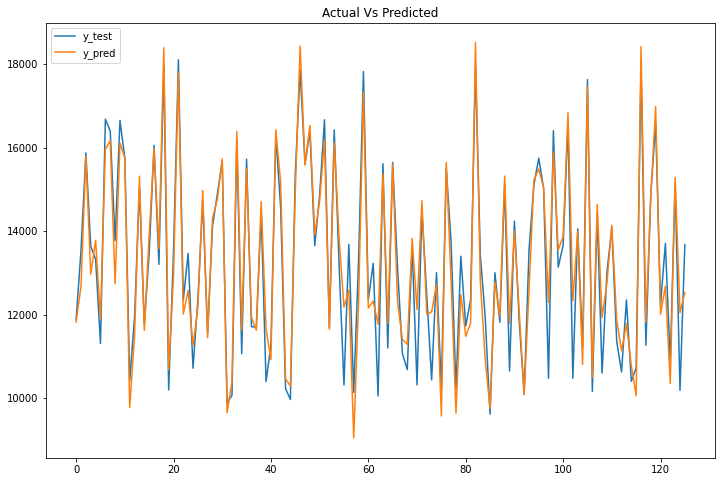

In [66]:
%matplotlib inline
dfYt = dfYt [['y_test', 'y_pred']]
dfYt.plot(title='Actual Vs Predicted', style=['-', '-'], figsize=(12,8))

In [24]:
model.score(x_train, y_train), model.score(x_test, y_test)

(0.9379938138478567, 0.9186120233227241)

In [25]:
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

Mean Absolute Error: 496.2985370004204
Mean Squared Error: 435980.02522676234
Root Mean Squared Error: 660.2878351346194


### Gradient Boosting Regressor

In [26]:
model = GradientBoostingRegressor(random_state=0).fit(x_train, y_train)
model.score(x_train, y_train), model.score(x_test, y_test)

/usr/local/lib/python3.7/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


(0.9802685280563921, 0.9386499868780175)

In [27]:
y_pred=model.predict(x_test)

#### To compare the predicted values y_pred with the actual output values y_test we will execute this script:

In [28]:
dfYt = pd.DataFrame(y_test, columns=['y_test'])
dfYp = pd.DataFrame(y_pred, columns=['y_pred'])
dfYt = dfYt.join(dfYp)
dfYt['difference']=dfYt['y_test']-dfYt['y_pred']
dfYt = dfYt[['y_test', 'y_pred', 'difference']]
dfYt

,y_test,y_pred,difference
0,11880.345449,11209.469571,670.875878
1,13544.718360,13326.825326,217.893034
2,15872.732578,16270.708053,-397.975476
3,13639.776538,13392.524265,247.252273
4,13325.314189,13265.145379,60.168811
...,...,...,...
121,13708.398660,13326.825326,381.573334
122,10856.664474,10322.524762,534.139712
123,15157.826232,15227.599361,-69.773129
124,10190.723381,11418.269183,-1227.545802


<AxesSubplot:title={'center':'Actual Vs Predicted'}>

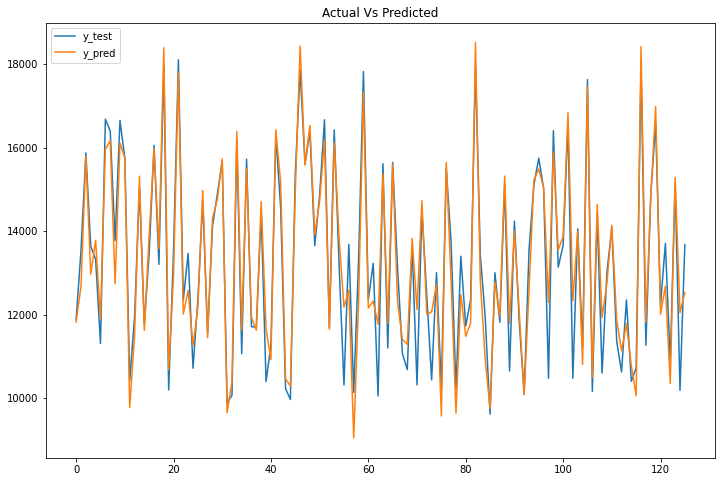

In [67]:
%matplotlib inline
dfYt = dfYt [['y_test', 'y_pred']]
dfYt.plot(title='Actual Vs Predicted', style=['-', '-'], figsize=(12,8))

In [29]:
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

Mean Absolute Error: 379.3557580742907
Mean Squared Error: 328640.43757524923
Root Mean Squared Error: 573.2716961225709


### Random Forest Regressor:

In [30]:
model = RandomForestRegressor(random_state=0).fit(x_train, y_train)
model.score(x_train, y_train), model.score(x_test, y_test)

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:1: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  """Entry point for launching an IPython kernel.


(0.9929147480761011, 0.9291165110210328)

In [31]:
y_pred=model.predict(x_test)

#### To compare the predicted values y_pred with the actual output values y_test we will execute this script:

In [47]:
dfYt = pd.DataFrame(y_test, columns=['y_test'])
dfYp = pd.DataFrame(y_pred, columns=['y_pred'])
dfYt = dfYt.join(dfYp)
dfYt['difference']=dfYt['y_test']-dfYt['y_pred']
dfYt = dfYt[['y_test', 'y_pred', 'difference']]
dfYt

,y_test,y_pred,difference
0,11880.345449,10500.830926,1379.514523
1,13544.718360,13378.567769,166.150591
2,15872.732578,16386.527527,-513.794949
3,13639.776538,13642.614058,-2.837521
4,13325.314189,13216.716241,108.597948
...,...,...,...
121,13708.398660,13463.923908,244.474752
122,10856.664474,10209.675851,646.988623
123,15157.826232,14935.354063,222.472168
124,10190.723381,11187.219673,-996.496292


<AxesSubplot:title={'center':'Actual Vs Predicted'}>

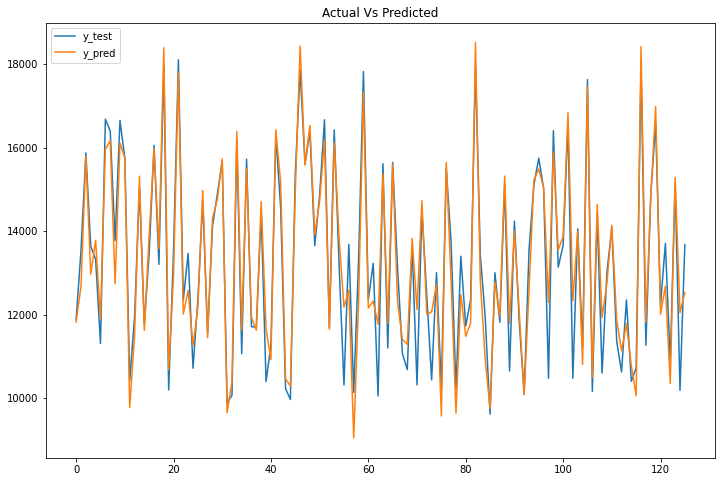

In [68]:
%matplotlib inline
dfYt = dfYt [['y_test', 'y_pred']]
dfYt.plot(title='Actual Vs Predicted', style=['-', '-'], figsize=(12,8))

In [33]:
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

Mean Absolute Error: 415.8824138563388
Mean Squared Error: 379709.4678462452
Root Mean Squared Error: 616.2057025427833


In [45]:
# https://github.com/hardikkamboj/An-Introduction-to-Statistical-Learning/blob/master/Chapter_8/Lab_8.3.3_Bagging_and_Random_Forests.ipynb
print(x_train.shape,x_test.shape)

(503, 1) (126, 1)


In [37]:
bagging = RandomForestRegressor(max_features=None)# or we can pass max_features = len(X_train.columns) = 13
bagging.fit(x_train,y_train)
print('Training score ',bagging.score(x_train,y_train))
print('Test Error ',bagging.score(x_test,y_test))

Training score  0.9926696925077924
Test Error  0.9309615091245407


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


In [69]:
rf = RandomForestRegressor(max_features = 1) # same as book
rf.fit(x_train,y_train)
print('Training score ',rf.score(x_train,y_train))
print('Test Error ',rf.score(x_test,y_test))

Training score  0.9927034426721402
Test Error  0.9303462242381203


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


In [44]:
#pd.Series(rf.feature_importances_,index = x_train).sort_values(ascending=False).plot.bar(figsize = (10,6))